In [1]:
import HCPD
import nibabel
import numpy as np, scipy.stats as stats
from sklearn.decomposition import PCA
from matplotlib import pyplot as plt

plt.style.use('ggplot')
CACHE_DIR = 'cache/'
DATA_DIR = 'data/1612710051843/'
if not os.path.isdir(DATA_DIR): os.mkdir(DATA_DIR)

In [25]:
def default_visualize(w, se, name = ''):
    n_keep = 3
    fig, axes = plt.subplots(1, n_keep, figsize = (12, 4))
    fig.suptitle(f'{name} - Components development' if name else 'Components development', fontsize = 20)
    cmap = ['#e2705f', '#6ca6c9', '#afa7dc']
    for i in range(n_keep):
        axes[i].errorbar(
            HCPD.AGES, [w[i] for w in w_mean.values()],
            yerr = [se[i] for se in w_se.values()],
            capsize = 4, color = cmap[i]
        )
        axes[i].set_title(f'PC{i+1}', y = -0.2)
        axes[i].set_xticks(np.arange(HCPD.AGES[0], HCPD.AGES[-1] + 2, 2))
    plt.tight_layout()
    plt.show()

# CC Map

In [2]:
maps = HCPD.getAllMaps(HCPD.getCerebrumMap)
np.save(os.path.join(DATA_DIR, 'Maps-HCPD-Cerebrum'), arr = maps)

Age: 8
Subjects: 15
Unprocessed: 0 in 15
Age: 9
Subjects: 15
Unprocessed: 0 in 15
Age: 10
Subjects: 15
Unprocessed: 0 in 15
Age: 11
Subjects: 15
Unprocessed: 0 in 15
Age: 12
Subjects: 15
Unprocessed: 0 in 15
Age: 13
Subjects: 15
Unprocessed: 0 in 15
Age: 14
Subjects: 15
Unprocessed: 0 in 15
Age: 15
Subjects: 15
Unprocessed: 0 in 15
Age: 16
Subjects: 15
Unprocessed: 0 in 15
Age: 17
Subjects: 15
Unprocessed: 0 in 15
Age: 18
Subjects: 15
Unprocessed: 0 in 15
Age: 19
Subjects: 17
Unprocessed: 0 in 17
Age: 20
Subjects: 15
Unprocessed: 0 in 15
Age: 21
Subjects: 15
Unprocessed: 0 in 15
Age: 22
Subjects: 7
Unprocessed: 0 in 7


In [2]:
maps = np.load(os.path.join(DATA_DIR, 'Maps-HCPD-Cerebrum.npy'), allow_pickle = True).item()

# Compute the accumulated counts of subjects, since all data will be stacked later
NAGES = len(HCPD.AGES)
accnsub = [0]
for i, arr in enumerate(maps.values()): 
    accnsub.append(accnsub[i] + arr.shape[0])
del i, arr

## PCA Analysis

In [3]:
maps = HCPD.setOutliersAsNan(maps)
matrix = np.row_stack(maps.values())
matrix = matrix.T

In [4]:
# Work through each feature, and set nan to mean
n_nan = []
for i in range(matrix.shape[1]):
    feature = matrix[:, i]
    fmean = np.nanmean(feature)
    indices = np.where(np.isnan(feature))
    n_nan.append(np.sum(np.isnan(feature)))
    matrix[indices, i] = fmean

print(stats.describe(n_nan))

DescribeResult(nobs=219, minmax=(184, 1496), mean=581.0365296803653, variance=60115.971136525484, skewness=0.8444470462341525, kurtosis=0.6375889502771006)


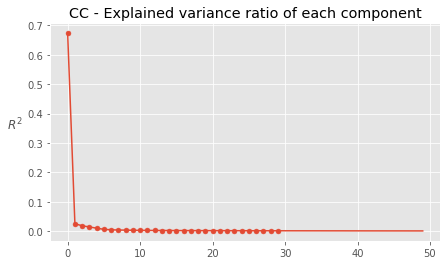

In [5]:
pca = PCA(n_components = 50)
pca.fit(matrix)

plt.figure(figsize = (7, 4))
plt.scatter(np.arange(30), pca.explained_variance_ratio_[:30], s = 24)
plt.plot(np.arange(50), pca.explained_variance_ratio_)
plt.ylabel('$R^2$', loc = 'center', rotation = 0, labelpad = 12)
plt.title('CC - Explained variance ratio of each component')
plt.show()

## Time profile

In [6]:
n_keep = 3
w_mean, w_se = {}, {}
for i, age in enumerate(HCPD.AGES):
    w_mean[age] = pca.components_[:n_keep, accnsub[i]: accnsub[i+1]].mean(axis=1)
    w_se[age] = pca.components_[:n_keep, accnsub[i]: accnsub[i+1]].std(axis=1, ddof=1) / maps[age].shape[0]

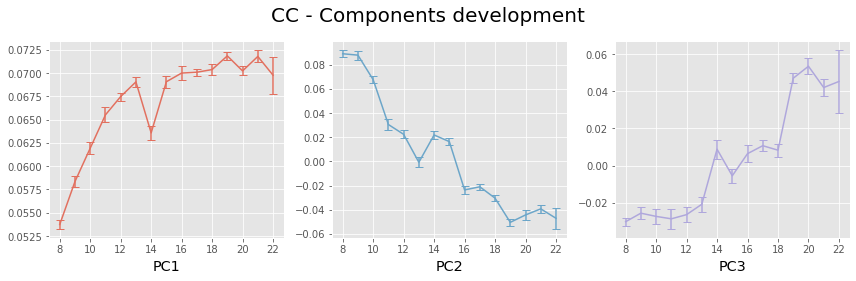

In [7]:
fig, axes = plt.subplots(1, n_keep, figsize = (12, 4))
fig.suptitle('CC - Components development', fontsize = 20)
cmap = ['#e2705f', '#6ca6c9', '#afa7dc']
for i in range(n_keep):
    # plt.plot(HCPD.AGES, [w[i] for w in w_mean.values()])
    axes[i].errorbar(
        HCPD.AGES, [w[i] for w in w_mean.values()],
        yerr = [se[i] for se in w_se.values()],
        capsize = 4, color = cmap[i]
    )
    axes[i].set_title(f'PC{i+1}', y = -0.2)
    axes[i].set_xticks(np.arange(HCPD.AGES[0], HCPD.AGES[-1] + 2, 2))
plt.tight_layout()
plt.show()

## Spatial map

In [10]:
# Get template from file
sub_id = HCPD.pickSubjectID()
sub_32kdir = HCPD.get32kDir(sub_id)
template = nibabel.load(os.path.join(sub_32kdir, f'{sub_id}_V1_MR.MyelinMap.32k_fs_LR.dscalar.nii'))
header = template.header
del sub_id, sub_32kdir, template

output = HCPD.normalize(pca.transform(matrix), 1, 2).T[:n_keep]
for i in range(n_keep):
    spatial_map = np.reshape(output[i], (1, 59412))
    obj = nibabel.cifti2.cifti2.Cifti2Image(spatial_map, header = header)
    nibabel.save(obj, os.path.join(DATA_DIR, f'CC-Spatial-Map-{i+1}.dscalar.nii'))

# SC Map

In [34]:
maps = HCPD.getAllMaps(HCPD.getSubcorticalMap)
np.save(os.path.join(DATA_DIR, 'Maps-HCPD-Subcortical'), arr = maps)

Age: 8
Subjects: 15
Unprocessed: 0 in 15
Age: 9
Subjects: 15
Unprocessed: 0 in 15
Age: 10
Subjects: 15
Unprocessed: 0 in 15
Age: 11
Subjects: 15
Unprocessed: 0 in 15
Age: 12
Subjects: 15
Unprocessed: 0 in 15
Age: 13
Subjects: 15
Unprocessed: 0 in 15
Age: 14
Subjects: 15
Unprocessed: 0 in 15
Age: 15
Subjects: 15
Unprocessed: 0 in 15
Age: 16
Subjects: 15
Unprocessed: 0 in 15
Age: 17
Subjects: 15
Unprocessed: 0 in 15
Age: 18
Subjects: 15
Unprocessed: 0 in 15
Age: 19
Subjects: 17
Unprocessed: 0 in 17
Age: 20
Subjects: 15
Unprocessed: 0 in 15
Age: 21
Subjects: 15
Unprocessed: 0 in 15
Age: 22
Subjects: 7
Unprocessed: 0 in 7


In [4]:
maps = np.load(os.path.join(DATA_DIR, 'Maps-HCPD-Subcortical.npy'), allow_pickle = True).item()

# Compute the accumulated counts of subjects, since all data will be stacked later
NAGES = len(HCPD.AGES)
accnsub = [0]
for i, arr in enumerate(maps.values()): 
    accnsub.append(accnsub[i] + arr.shape[0])
del i, arr

## PCA analysis

In [5]:
maps = HCPD.setOutliersAsNan(maps)
matrix = np.row_stack(maps.values())
matrix = matrix.T

In [6]:
# Work through each feature, and set nan to mean
n_nan = []
for i in range(matrix.shape[1]):
    feature = matrix[:, i]
    fmean = np.nanmean(feature)
    indices = np.where(np.isnan(feature))
    n_nan.append(np.sum(np.isnan(feature)))
    matrix[indices, i] = fmean

print(stats.describe(n_nan))

DescribeResult(nobs=219, minmax=(2, 639), mean=38.3013698630137, variance=3023.46839261028, skewness=7.338406693461666, kurtosis=69.86016471169603)


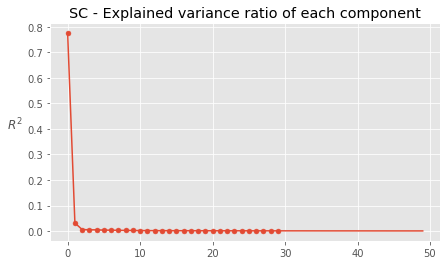

In [9]:
pca = PCA(n_components = 50)
pca.fit(matrix)

plt.figure(figsize = (7, 4))
plt.scatter(np.arange(30), pca.explained_variance_ratio_[:30], s = 24)
plt.plot(np.arange(50), pca.explained_variance_ratio_)
plt.ylabel('$R^2$', loc = 'center', rotation = 0, labelpad = 12)
plt.title('SC - Explained variance ratio of each component')
plt.show()

## Time profile

In [8]:
n_keep = 3
w_mean, w_se = {}, {}
for i, age in enumerate(HCPD.AGES):
    w_mean[age] = pca.components_[:n_keep, accnsub[i]: accnsub[i+1]].mean(axis=1)
    w_se[age] = pca.components_[:n_keep, accnsub[i]: accnsub[i+1]].std(axis=1, ddof=1) / maps[age].shape[0]

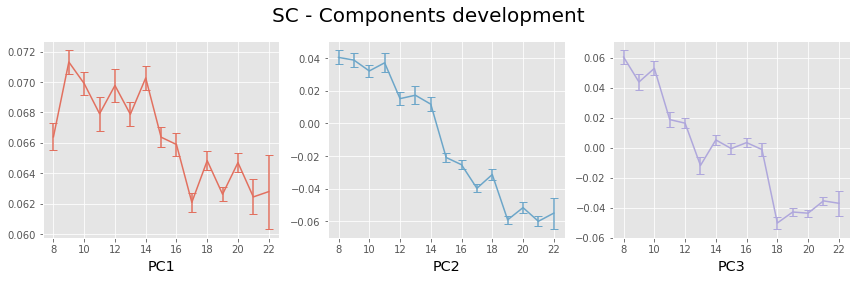

In [10]:
fig, axes = plt.subplots(1, n_keep, figsize = (12, 4))
fig.suptitle('SC - Components development', fontsize = 20)
cmap = ['#e2705f', '#6ca6c9', '#afa7dc']
for i in range(n_keep):
    # plt.plot(HCPD.AGES, [w[i] for w in w_mean.values()])
    axes[i].errorbar(
        HCPD.AGES, [w[i] for w in w_mean.values()],
        yerr = [se[i] for se in w_se.values()],
        capsize = 4, color = cmap[i]
    )
    axes[i].set_title(f'PC{i+1}', y = -0.2)
    axes[i].set_xticks(np.arange(HCPD.AGES[0], HCPD.AGES[-1] + 2, 2))
plt.tight_layout()
plt.show()

## Spatial map

In [11]:
output = HCPD.normalize(pca.transform(matrix), 1, 2).T[:n_keep]
for i in range(n_keep):
    spatial_map = HCPD.getNibabelObj(HCPD.invertMyelinationMap(output[i]))
    nibabel.save(spatial_map, os.path.join(DATA_DIR, f'SC-Spatial-Map-{i+1}.nii'))